In [1]:
import sys
sys.path.append("/home/kortkamp/BG/lightning_bg/src/lightning_bg")
from evaluate import Evaluator, ShowTraj
from architectures import get_network_by_name, BaseHParams
from utils import dataset_setter
import os
import bgmol
from bgmol.systems.peptide import peptide
import yaml
import mdtraj

In [2]:
data_path = "./data"
param_path = "./params"
molecule = "/OppA/Peptides/1qka" # change this for different molecule 
experiment_name = "RNVPfwkl.yaml" # change this for different experiment
version = 1 # change this for different version

In [3]:
molecule_path = os.path.join(data_path, "Molecules", molecule.lstrip("/"))
molecule_path

'./data/Molecules/OppA/Peptides/1qka'

In [4]:
if "Dialanine" in molecule:
    is_data_here = os.path.exists(molecule_path + "/Ala2TSF300.npy")
    ala_data = bgmol.datasets.Ala2TSF300(download=not is_data_here, read=True, root=molecule_path)
    system = ala_data.system
    n_atoms = 22
else:
    with open(molecule_path.rstrip("/") + "/top.pdb", 'r') as file:
        lines = file.readlines()
        lastline = lines[-3]
        n_atoms = int(lastline[4:11].strip())
        n_res = int(lastline[22:26].strip())
        print(n_atoms, n_res)

    # define system & energy model
    system = peptide(short=False, n_atoms=n_atoms, n_res=n_res, filepath=molecule_path)

71 3


In [5]:
experiment_path = os.path.join(param_path, molecule.lstrip("/"), experiment_name)
with open(experiment_path) as f:  # TODO: this is stupid bc there is a hparams file in the version folder. use it instead!!
    params = yaml.load(f, yaml.FullLoader)  # load the parameters
ModelClass = get_network_by_name(params['network_name'])
ParamClass = BaseHParams
params['network_params']['n_dims'] = n_atoms * 3
hparams = ParamClass(**params['network_params'])
checkpoint = os.path.join(data_path, "lightning_logs", molecule.lstrip("/"), experiment_name[:-5], f"version_{version}", "checkpoints/epoch=4899-step=343000.ckpt")
# checkpoint = "/home/kortkamp/helix/code/lightning_bg/data/lightning_logs/OppA/Peptides/1b4z/params/OppA/1b4z/RNVPfwkl20000/version_0/checkpoints/last.ckpt"

if "Dialanine" in molecule:
    coordinates = ala_data.coordinates
else:
    traj = mdtraj.load_hdf5(molecule_path + "/traj.h5")
    coordinates = traj.xyz
train_split = params['training_params']['train_split']    
train_data, val_data, test_data = dataset_setter(coordinates, system, val_split=(.8 - train_split), test_split=.2, seed=42)

model = ModelClass.load_from_checkpoint(checkpoint, hparams=hparams, train_data=train_data, val_data=val_data)

/home/kortkamp/mambaforge/envs/lightning_bg/lib/python3.10/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.0' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


tensor([ 0.7923,  1.8191,  1.5563,  0.8435,  1.8985,  1.5922,  0.8607,  1.7636,
         1.5069,  0.7596,  1.7614,  1.6325,  0.6885,  1.8673,  1.4562,  0.7362,
         1.9403,  1.3908,  0.5673,  1.9312,  1.5215,  0.5368,  1.9024,  1.6390,
         0.6370,  1.7533,  1.3624,  0.7176,  1.7068,  1.3057,  0.5704,  1.7974,
         1.2882,  0.5528,  1.6519,  1.4389,  0.4752,  1.7134,  1.4844,  0.6221,
         1.6103,  1.5121,  0.4806,  1.5367,  1.3601,  0.4113,  1.5706,  1.2831,
         0.4213,  1.4760,  1.4285,  0.5768,  1.4462,  1.2796,  0.5208,  1.3808,
         1.2128,  0.6452,  1.5017,  1.2154,  0.6517,  1.3520,  1.3711,  0.7498,
         1.3750,  1.3777,  0.6528,  1.2528,  1.3524,  0.6101,  1.3609,  1.4627,
         0.5103,  2.0324,  1.4600,  0.5439,  2.0464,  1.3658,  0.3852,  2.0901,
         1.4995,  0.3709,  2.0882,  1.6076,  0.2718,  2.0085,  1.4473,  0.2924,
         1.9320,  1.3540,  0.3849,  2.2342,  1.4406,  0.2892,  2.2834,  1.4578,
         0.4017,  2.2253,  1.3333,  0.48

In [6]:
params

{'molecule': '/OppA/Peptides/1qka',
 'network_name': 'RNVPfwkl',
 'network_params': {'inn_depth': 10,
  'subnet_max_width': 2000,
  'subnet_depth': 8,
  'batch_size': 1000,
  'max_epochs': 20000,
  'optimizer': {'name': 'Adam', 'lr': 3e-05},
  'lr_scheduler': 'onecyclelr',
  'latent_target_distribution': {'name': 'Normal', 'sigma': 1.0},
  'gradient_clip': 10.0,
  'n_dims': 213},
 'training_params': {'train_split': 0.7},
 'trainer_kwargs': {}}

In [7]:
x = model.generate_samples((100,))
w = ShowTraj(x, system)

In [8]:
w

ShowTraj(children=(NGLWidget(max_frame=99), BoundedFloatText(value=2214431.25, description='Energy:', max=1e+5…

(<Figure size 640x480 with 1 Axes>,
 <AxesSubplot:xlabel='Energy [$k_B T$]', ylabel='# samples'>)

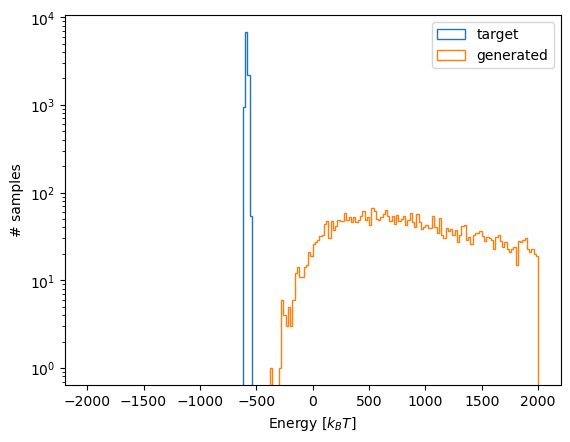

In [11]:
E = Evaluator(model, system)
E.energy_plot(rg=[-2000, 2000])